In [1]:
import os

import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatterMathtext

In [2]:
DATA_DIR = "../data/benchmarks/"
NUM_GAMES = 500
NUM_WARMUP_GAMES = 100
BATCH_SIZE = 2
NUM_BATCH_SIZES = 16
THREAD_NUMS = [1, 16, 32]

In [3]:
def get_data_from_cache(game: str):
    cache_str = f"cache-{game}-{NUM_GAMES}-{NUM_WARMUP_GAMES}-{BATCH_SIZE}-{NUM_BATCH_SIZES}.npz"
    full_path = os.path.join(DATA_DIR, game, cache_str)
    cache = np.load(full_path, allow_pickle=True)

    batch_sizes = cache['batch_sizes']
    ludii_moves_per_second = cache['ludii_moves_per_second']
    ldx_times = cache['ldx_times']
    ldx_total_steps = cache['ldx_total_steps']
    pgx_times = cache.get('pgx_times')
    pgx_total_steps = cache.get('pgx_total_steps')

    average_ldx_moves_per_second = np.mean(ldx_total_steps / ldx_times, axis=1)
    std_ldx_moves_per_second = np.std(ldx_total_steps / ldx_times, axis=1)

    if pgx_times.any():
        average_pgx_moves_per_second = np.mean(pgx_total_steps / pgx_times, axis=1)
        std_pgx_moves_per_second = np.std(pgx_total_steps / pgx_times, axis=1)

    else:
        average_pgx_moves_per_second = None
        std_pgx_moves_per_second = None

    return batch_sizes, ludii_moves_per_second, average_ldx_moves_per_second, std_ldx_moves_per_second, average_pgx_moves_per_second, std_pgx_moves_per_second

In [20]:
def style_log_axes(ax, batch_sizes, left_factor=0.6, right_factor=1.5):
    max_bs = max(batch_sizes)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(left_factor, right_factor * max_bs)
    ax.set_ylim(1e3, 1e9)
    ax.xaxis.set_major_locator(LogLocator(base=2, subs=[1.0], numticks=len(batch_sizes)))
    ax.xaxis.set_major_formatter(LogFormatterMathtext(base=2))
    ax.xaxis.set_minor_locator(LogLocator(base=2, subs='auto', numticks=len(batch_sizes)*8))
    ax.xaxis.set_minor_formatter(LogFormatterMathtext(base=2))
    ax.grid(True, which='major', linestyle=':', linewidth=0.8, alpha=0.8)

    ax.tick_params(axis='both', labelsize=10)

eb_kwargs = {
    'linestyle':       '-',
    'linewidth':        1.5,
    'capsize':          4,
    'elinewidth':       1,
    'markeredgewidth':  1
}

# General configuration
mpl.rcParams.update({
    "text.usetex": False, 
    "font.family": "serif",     
    "font.size": 8,        
    "axes.titlesize": 14,
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 10,
    "figure.titlesize": 14,
    "lines.linewidth": 1.2,
    "lines.markersize": 4,
    "axes.linewidth": 0.8,
    "legend.frameon": True,
    "legend.loc": "lower right",
    "xtick.major.width": 0.8,
    "ytick.major.width": 0.8,
    "savefig.dpi": 300,
    "savefig.bbox": "tight",
    "pdf.fonttype": 42,
    "ps.fonttype": 42
})

colors = ['#3599BF', '#CE6661', '#64B268', '#3298BE', '#E68656']


Game 'tic_tac_toe': 48.61× faster than Ludii (380450683.42556953 vs. 7826588.16 moves/sec)
Game 'tic_tac_toe': 0.93× faster than PGX (380450683.42556953 vs. 408491500.67 moves/sec)

Game 'connect_four': 11.31× faster than Ludii (75342865.958993 vs. 6662758.86 moves/sec)
Game 'connect_four': 0.36× faster than PGX (75342865.958993 vs. 206591616.64 moves/sec)

Game 'hex': 2.95× faster than Ludii (41826987.97507167 vs. 14201079.14 moves/sec)
Game 'hex': 0.34× faster than PGX (41826987.97507167 vs. 121415232.18 moves/sec)

Game 'reversi': 21.02× faster than Ludii (14835659.070173299 vs. 705660.66 moves/sec)
Game 'reversi': 0.23× faster than PGX (14835659.070173299 vs. 65741290.81 moves/sec)

Game 'gomoku': 4.91× faster than Ludii (36694059.33716723 vs. 7469291.20 moves/sec)

Game 'pente': 70.84× faster than Ludii (18933624.249035075 vs. 267272.18 moves/sec)

Game 'yavalath': 19.99× faster than Ludii (116948871.391612 vs. 5849203.77 moves/sec)

Game 'yavalax': 8.88× faster than Ludii (44463

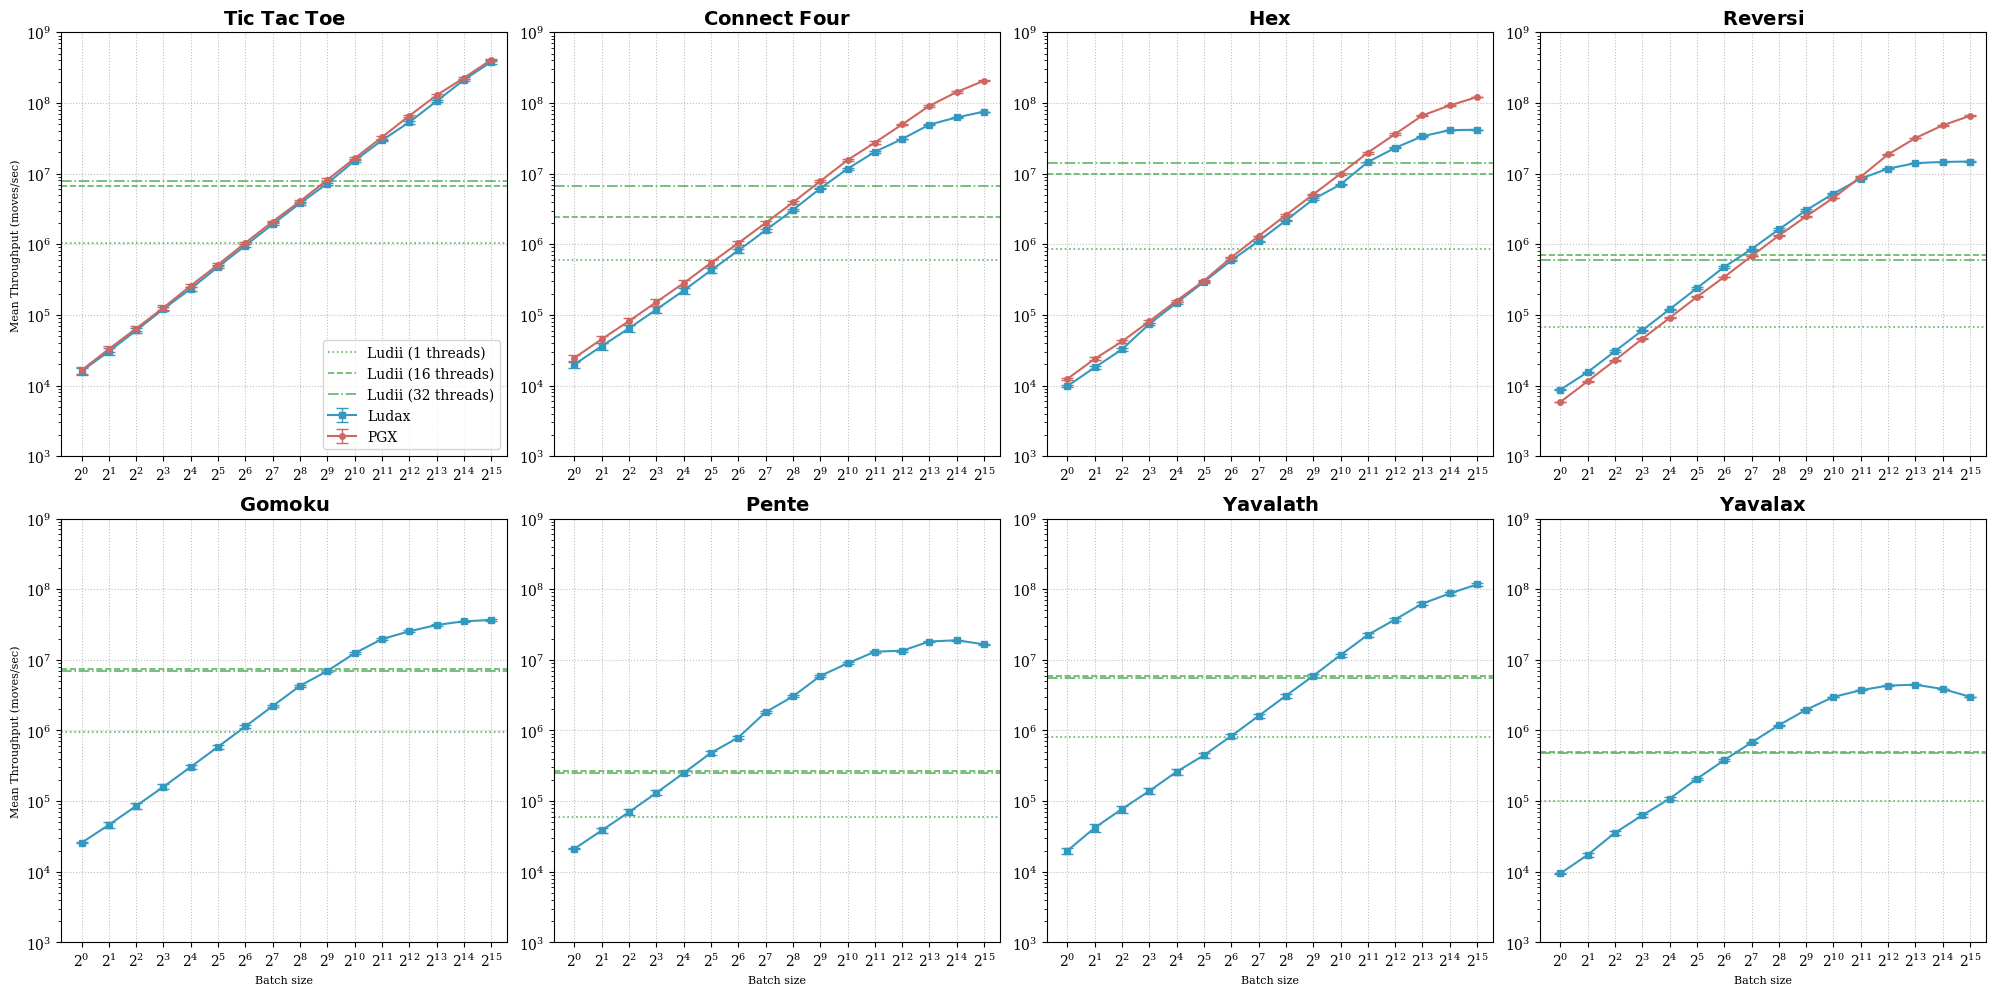

In [22]:
GAMES = [
    ["tic_tac_toe", "connect_four", "hex", "reversi"],
    ["gomoku", "pente", "yavalath", "yavalax"]
]

fig, axs = plt.subplots(len(GAMES), len(GAMES[0]), figsize=(20, 10))

for i, row in enumerate(GAMES):
    for j, game in enumerate(row):
        ax = axs[i][j]

        batch_sizes, ludii_moves_per_second, average_ldx_moves_per_second, std_ldx_moves_per_second, average_pgx_moves_per_second, std_pgx_moves_per_second = get_data_from_cache(game)

        ax.errorbar(batch_sizes, average_ldx_moves_per_second, yerr=std_ldx_moves_per_second, marker='s', color=colors[0], label='Ludax', **eb_kwargs)
        if average_pgx_moves_per_second is not None:
            ax.errorbar(batch_sizes, average_pgx_moves_per_second, yerr=std_pgx_moves_per_second, marker='o', color=colors[1], label='PGX', **eb_kwargs)

        line_styles = [':', '--', '-.']
        for k, num_threads in enumerate(THREAD_NUMS):
            ludii_ms = ludii_moves_per_second[k]
            ax.axhline(y=ludii_ms, linestyle=line_styles[k], label=f'Ludii ({num_threads} threads)', color=colors[2], alpha=1)

        style_log_axes(ax, batch_sizes)

        if i == 1:
            ax.set_xlabel('Batch size')

        if j == 0:
            ax.set_ylabel('Mean Throughput (moves/sec)')

        formatted_title = "{" + game.title().replace('_', '\\text{ }') + "}"
        ax.set_title(f"$\\bf{formatted_title}$")

        if i == 0 and j == 0:
            ax.legend()

        fastest_ludii_speed = max(ludii_moves_per_second)
        fastest_ldx_speed = max(average_ldx_moves_per_second)
        print(f"\nGame '{game}': {fastest_ldx_speed / fastest_ludii_speed:.2f}× faster than Ludii ({fastest_ldx_speed} vs. {fastest_ludii_speed:.2f} moves/sec)")

        if average_pgx_moves_per_second is not None:
            fastest_pgx_speed = max(average_pgx_moves_per_second)
            print(f"Game '{game}': {fastest_ldx_speed / fastest_pgx_speed:.2f}× faster than PGX ({fastest_ldx_speed} vs. {fastest_pgx_speed:.2f} moves/sec)")

handles, labels = axs[0][0].get_legend_handles_labels()
fig.tight_layout()
fig.savefig("../renders/throughput_comparison.pdf")